In [27]:

import pandas as pd
import numpy as np
import datetime as dt

In [28]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Machine Learning - Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [30]:
# Machine Learning - CLV Prediction
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [31]:
# Machine Learning - Churn Prediction
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Ignore warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')



In [32]:

df = pd.read_excel("/content/online_retail_II.xlsx", sheet_name="Year 2010-2011")
print("Dataset loaded successfully.")


Dataset loaded successfully.


In [33]:
# --- Data Cleaning ---
# Drop rows without a CustomerID
df.dropna(subset=['Customer ID'], inplace=True)

# Remove cancelled orders (invoices starting with 'C')
df = df[~df['Invoice'].astype(str).str.contains('C', na=False)]

In [34]:
# Remove transactions with non-positive quantity or price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Correct data types
df['Customer ID'] = df['Customer ID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

print("Data cleaning and preprocessing complete.")
print(f"Dataset shape after cleaning: {df.shape}")
print(df.head())

Data cleaning and preprocessing complete.
Dataset shape after cleaning: (397885, 9)
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  
0 2010-12-01 08:26:00   2.55        17850  United Kingdom       15.30  
1 2010-12-01 08:26:00   3.39        17850  United Kingdom       20.34  
2 2010-12-01 08:26:00   2.75        17850  United Kingdom       22.00  
3 2010-12-01 08:26:00   3.39        17850  United Kingdom       20.34  
4 2010-12-01 08:26:00   3.39        17850  United Kingdom       20.34  


In [35]:
# --- RFM Feature Engineering ---
# Set a snapshot date for recency calculation (one day after the last transaction)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate RFM values for each customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

# Rename the columns
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'Invoice': 'Frequency',
                    'TotalPrice': 'Monetary'}, inplace=True)

print("\nRFM features generated successfully.")
print(rfm.head())


RFM features generated successfully.
             Recency  Frequency  Monetary
Customer ID                              
12346            326          1  77183.60
12347              2          7   4310.00
12348             75          4   1797.24
12349             19          1   1757.55
12350            310          1    334.40


In [36]:
# --- Advanced Feature Engineering ---
# Calculate the time between a customer's first and last purchase (Tenure)
df_tenure = df.groupby('Customer ID')['InvoiceDate'].agg(['min', 'max']).reset_index()
df_tenure['Tenure'] = (df_tenure['max'] - df_tenure['min']).dt.days

# Calculate average time between purchases
df_purchase_freq = df.groupby(['Customer ID', 'Invoice'])['InvoiceDate'].count().reset_index()
df_avg_time = df_purchase_freq.groupby('Customer ID')['InvoiceDate'].count().reset_index()
# Merge tenure with average purchase time
df_features = pd.merge(df_tenure, df_avg_time, on='Customer ID')
df_features['AvgTimeBetweenPurchases'] = (df_features['Tenure'] / df_features['InvoiceDate']).fillna(0)

# Merge these new features into the churn_df
churn_df = pd.merge(churn_df, df_features[['Customer ID', 'AvgTimeBetweenPurchases']], on='Customer ID', how='left')

print("\nAdvanced features generated and merged.")
print(churn_df.head())


Advanced features generated and merged.
   Customer ID  Recency  Frequency  Monetary  Cluster              Segment  \
0        12347        2          7   4310.00        1              At-Risk   
1        12348       75          4   1797.24        2  Potential Loyalists   
2        12352       36          8   2506.04        2  Potential Loyalists   
3        12356       23          3   2811.43        2  Potential Loyalists   
4        12358        2          2   1168.06        0            Champions   

       T  Churn  AvgTimeBetweenPurchases_x  AvgTimeBetweenPurchases_y  
0  367.0      0                  52.142857                  52.142857  
1  358.0      0                  70.500000                  70.500000  
2  297.0      0                  32.500000                  32.500000  
3  326.0      0                 100.666667                 100.666667  
4  151.0      0                  74.500000                  74.500000  



--- Phase 2: Customer Segmentation ---


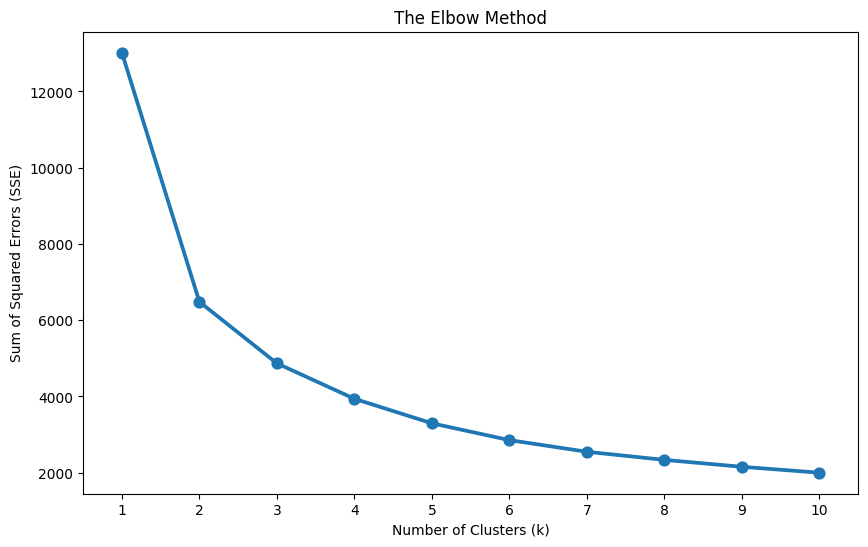


Cluster analysis (mean RFM values):
   Cluster     Recency  Frequency     Monetary
0        0   18.124253   2.148148   551.841039
1        1   12.131285  13.713687  8074.266872
2        2   71.084399   4.083546  1802.829005
3        3  182.496898   1.318238   343.450032


In [37]:
# ==============================================================================
# Phase 2: Customer Segmentation with K-Means
# ==============================================================================
print("\n--- Phase 2: Customer Segmentation ---")

# Handle skewness in data with log transformation
rfm_log = np.log1p(rfm)

# Scale the data using StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

# Use the Elbow Method to find the optimal number of clusters
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

# Based on the elbow plot, 4 clusters appear to be a good choice.
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_

# Analyze and interpret the clusters
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print("\nCluster analysis (mean RFM values):")
print(cluster_analysis)

In [38]:
# ==============================================================================
# Phase 3: Predictive Modelling - Customer Lifetime Value (CLV) - FIXED
# ==============================================================================
print("\n--- Phase 3: Customer Lifetime Value (CLV) Prediction ---")

# Prepare data for the `lifetimes` library
clv_data = df.groupby('Customer ID').agg({
    'InvoiceDate': [lambda date: (date.max() - date.min()).days, # recency
                    lambda date: (snapshot_date - date.min()).days], # T
    'Invoice': 'nunique', # This will be adjusted to 'frequency'
    'TotalPrice': 'sum'
})

clv_data.columns = ['recency', 'T', 'frequency', 'monetary_value']

# 💡 FIX: Adjust 'frequency' to be the number of REPEAT purchases.
# The lifetimes library expects frequency to be count of purchases - 1.
clv_data['frequency'] = clv_data['frequency'] - 1


# Calculate average monetary value per transaction
clv_data['monetary_value'] = clv_data['monetary_value'] / (clv_data['frequency'] + 1) # Use original total count

# Filter out customers with no repeat purchases (frequency = 0)
clv_data = clv_data[clv_data['frequency'] > 0]

# Remove outliers from monetary value to aid convergence of the Gamma-Gamma model
clv_data = clv_data[clv_data['monetary_value'] < clv_data['monetary_value'].quantile(0.99)]


# Fit the Beta-Geometric/Negative Binomial Distribution (BG/NBD) model
bgf = BetaGeoFitter(penalizer_coef=0.001) # A small penalizer is usually best
bgf.fit(clv_data['frequency'], clv_data['recency'], clv_data['T'])


# Fit the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(clv_data['frequency'], clv_data['monetary_value'])


# Predict the CLV for the next 12 months (365 days)
clv_data['predicted_clv_12_months'] = ggf.customer_lifetime_value(
    bgf,
    clv_data['frequency'],
    clv_data['recency'],
    clv_data['T'],
    clv_data['monetary_value'],
    time=12,  # 12 months
    discount_rate=0.01  # monthly discount rate
)

print("\nCLV prediction complete. Top 10 customers by predicted CLV:")
print(clv_data.sort_values(by='predicted_clv_12_months', ascending=False).head(10))


--- Phase 3: Customer Lifetime Value (CLV) Prediction ---

CLV prediction complete. Top 10 customers by predicted CLV:
             recency    T  frequency  monetary_value  predicted_clv_12_months
Customer ID                                                                  
14911            372  373        200      715.547562            106564.380696
16029            335  374         62     1286.108571             52945.647598
13694            369  374         49     1300.792400             48508.370225
15311            373  374         90      667.779121             45095.368181
13089            366  370         96      606.451856             44006.555822
17949            370  371         44     1300.232889             44002.251791
15061            368  372         47     1136.127917             40877.995926
14298            352  360         43     1171.075000             39694.148377
18139              0   18          5     1406.390000             30483.175300
17841            371  


--- Phase 4: Customer Churn Prediction ---
Churn Model AUC Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       774
           1       0.99      0.99      0.99        71

    accuracy                           1.00       845
   macro avg       0.99      0.99      0.99       845
weighted avg       1.00      1.00      1.00       845



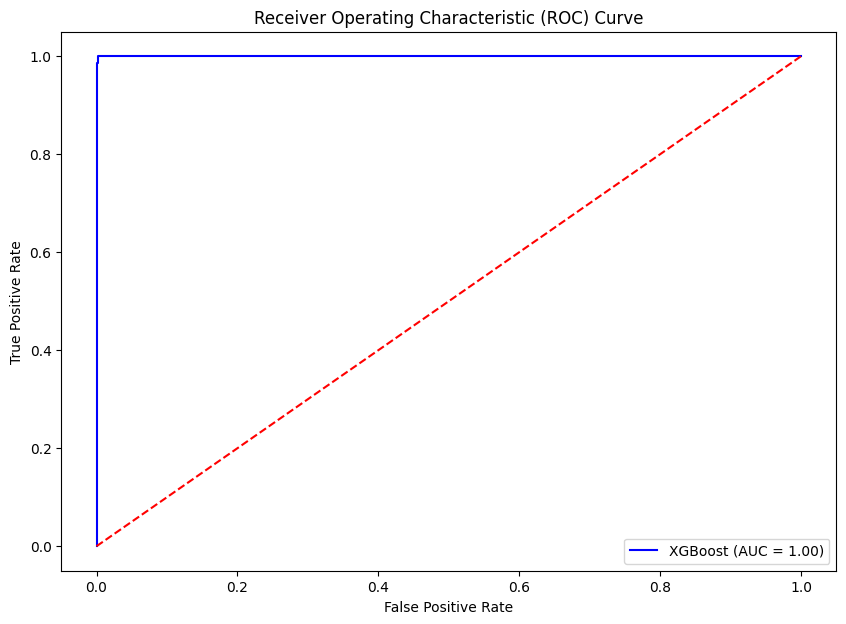

In [41]:
# ==============================================================================
# Phase 4: Predictive Modelling - Customer Churn
# ==============================================================================
print("\n--- Phase 4: Customer Churn Prediction ---")

# Merge RFM data with CLV tenure data
churn_df = pd.merge(rfm, clv_data[['T']], on='Customer ID', how='left')
churn_df.dropna(inplace=True)

# Merge the advanced features (including AvgTimeBetweenPurchases) into churn_df
churn_df = pd.merge(churn_df, df_features[['Customer ID', 'AvgTimeBetweenPurchases']], on='Customer ID', how='left')


# Define churn: A customer is considered churned if their last purchase was > 180 days ago
churn_df['Churn'] = (churn_df['Recency'] > 180).astype(int)

# Select features and target
features = ['Recency', 'Frequency', 'Monetary', 'T', 'AvgTimeBetweenPurchases'] # Added AvgTimeBetweenPurchases here
target = 'Churn'

X = churn_df[features]
y = churn_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train an XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluate the model
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Churn Model AUC Score: {auc_score:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label=f'XGBoost (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


--- SHAP Summary Plot ---


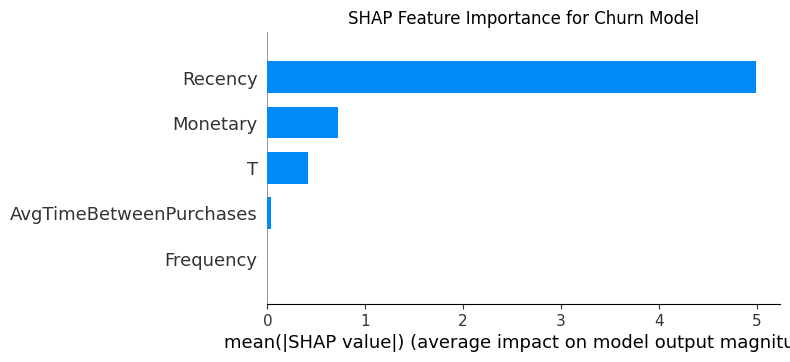


--- Detailed SHAP Summary Plot ---


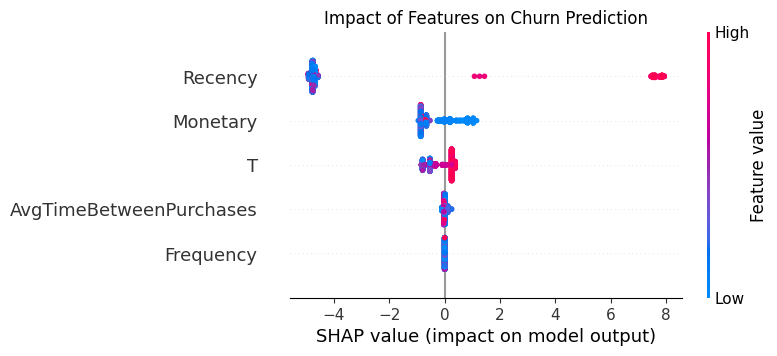

In [42]:
# Make sure you have shap installed: pip install shap
import shap

# --- Model Explainability with SHAP ---
# Update the features list to include our new feature
features = ['Recency', 'Frequency', 'Monetary', 'T', 'AvgTimeBetweenPurchases']
target = 'Churn'

X = churn_df[features]
y = churn_df[target]

# Retrain the model with the new feature (or use the previously trained one)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
xgb_clf.fit(X_train, y_train)

# Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

# Plot the summary of SHAP values to see feature importance
print("\n--- SHAP Summary Plot ---")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for Churn Model")
plt.show()

# Detailed summary plot
print("\n--- Detailed SHAP Summary Plot ---")
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Impact of Features on Churn Prediction")
plt.show()

In [43]:
from sklearn.utils.class_weight import compute_sample_weight

# --- Handling Class Imbalance ---
# Calculate the ratio of negative to positive class samples
neg, pos = np.bincount(y_train)
scale_pos_weight_value = neg / pos

# Train a new XGBoost Classifier with the weight parameter
xgb_clf_balanced = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight_value, # Added parameter
    random_state=42
)
xgb_clf_balanced.fit(X_train, y_train)

# Re-evaluate the model
y_pred_balanced = xgb_clf_balanced.predict(X_test)
print("\n--- Classification Report (Balanced Model) ---")
print(classification_report(y_test, y_pred_balanced))


--- Classification Report (Balanced Model) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       774
           1       0.99      0.99      0.99        71

    accuracy                           1.00       845
   macro avg       0.99      0.99      0.99       845
weighted avg       1.00      1.00      1.00       845




--- Phase 5: Generating Key Visualizations for Dashboard ---


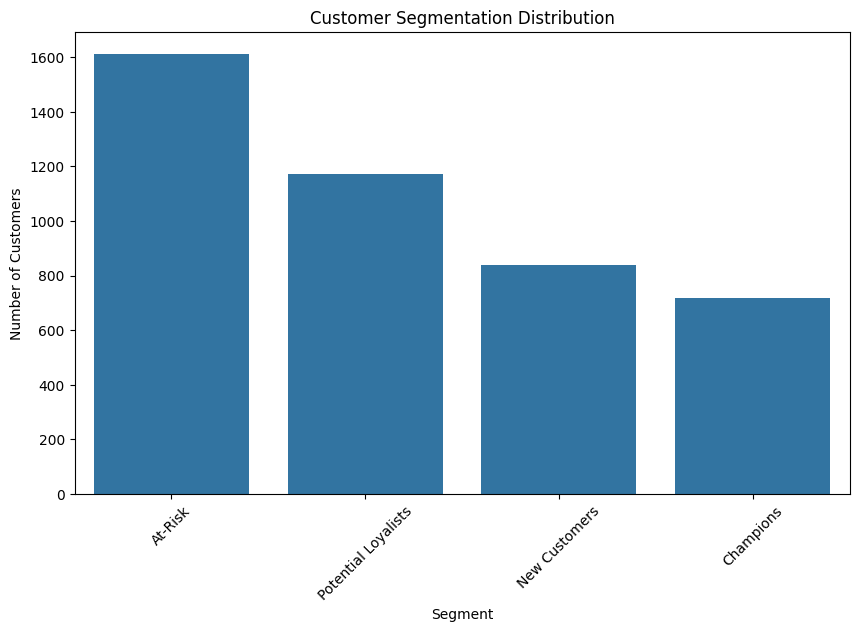

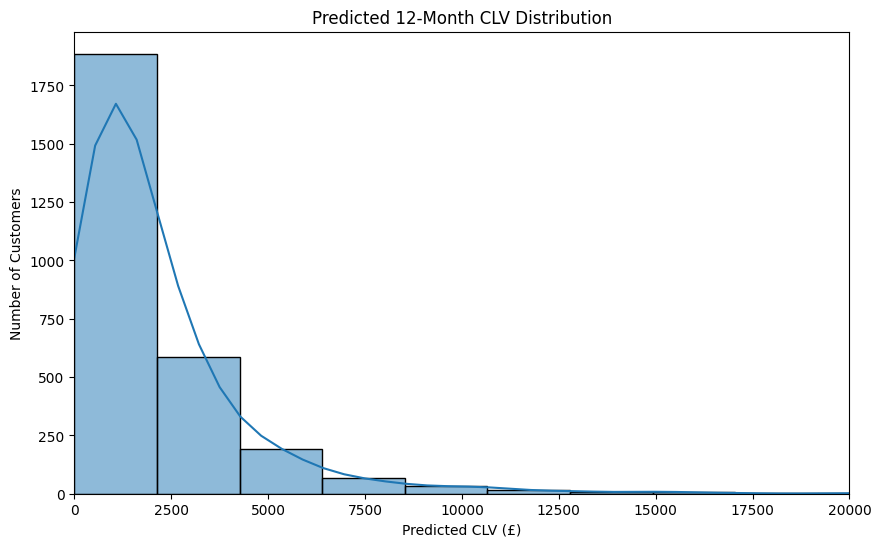

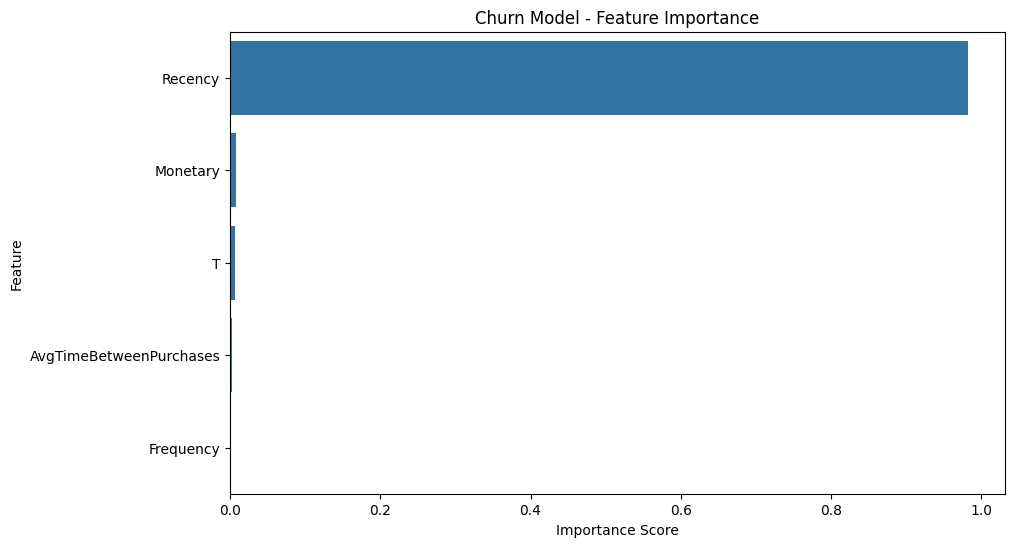

In [45]:
# ==============================================================================
# Phase 5: Visualization and Reporting
# ==============================================================================
print("\n--- Phase 5: Generating Key Visualizations for Dashboard ---")

# Add a 'Segment' column based on the cluster analysis for better visualization
# You can define segment names based on your cluster analysis (e.g., using the cluster_analysis DataFrame)
cluster_map = {0: 'New Customers', 1: 'Champions', 2: 'Potential Loyalists', 3: 'At-Risk'} # Example mapping, adjust based on your analysis
rfm['Segment'] = rfm['Cluster'].map(cluster_map)


# 1. Customer Segmentation Distribution
plt.figure(figsize=(10, 6))
# Use the 'Segment' column for plotting and order by value counts
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segmentation Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

# 2. Predicted CLV Distribution
plt.figure(figsize=(10, 6))
sns.histplot(clv_data['predicted_clv_12_months'], bins=50, kde=True)
plt.title('Predicted 12-Month CLV Distribution')
plt.xlabel('Predicted CLV (£)')
plt.ylabel('Number of Customers')
plt.xlim(0, 20000) # Capping x-axis for better visibility
plt.show()

# 3. Churn Drivers (Feature Importance)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Churn Model - Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()